In [1]:
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
import numpy as np

# Supported files:
# 1. a9a.txt
# 2. w8a.txt
# 3. ijcnn1
# 4. covtype.libsvm.binary

def data_loader(file_name='a9a.txt'):
    # Load in data and get rid of last column
    X, y = load_svmlight_file(file_name)
    
    # Convert to numpy array
    X = X.todense()
    return X, y



In [3]:
X, y = data_loader('a9a.txt')

print(X.shape)

(32561, 123)


In [4]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.covariance import GraphicalLasso

cov = GraphicalLasso(max_iter=1000).fit(X_train)

A = cov.covariance_

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_graph_lasso.py:318: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.703e+01
  ConvergenceWarning,


In [7]:
def lossfn(U, w, x, A, lambda_=1e-5):
    # U -> input, w -> label
    f = np.mean( 1 / ( 1 + np.exp(np.dot(U, x) * w)) ) 
    g = lambda_ * np.linalg.norm(np.dot(A, x), ord=1)
    return f + g

In [8]:
def gradf(U, w, x):
    # U (n,d) ; w (n,1) ; x (d,1)
    expfn = 1 / ( 1 + np.exp(np.dot(U, x) * w)) # (n,1)
    return np.mean( expfn * ( expfn - 1 ) * (U * w), axis = 0).reshape(x.shape)

In [9]:
def soft_threshold(x, t=1):
    return np.sign(x) * np.maximum( np.abs(x) - t, 0)

def update_y(x, y, z, rho, A, lambda_):
    return 1 / (rho + 1) * soft_threshold(rho * np.dot(A, x) + y - z, lambda_)

In [10]:
def update_x(x, y, z, v, rho, eta, A):
    return x - eta * ( v + rho * np.dot(A, (np.dot(A, x) - y - z / rho) ))

In [11]:
def update_s(rho, A, B, z_1, z_0):
    return rho * A.T @ B @ (z_1 - z_0)

def update_r(A, B, x, z, c):
    return A @ x + B @ z - c

def update_rho(rho, r, s, mu=1.25, tau_incr=1.25, tau_decr=1.25):
    r_n = np.linalg.norm(r, ord=2)
    s_n = np.linalg.norm(s, ord=2)
    if r_n > mu*s_n:
        return tau_incr * rho
    if s_n > mu*r_n:
        return rho / tau_decr
    return rho

In [83]:
# U = X_train
# w = y_train
def spider_admm(b, q, K, eta, rho, U, w, A, lambda_):
    n, d = U.shape
    x = np.zeros((d,1)) # ai^\top x_i 
    y = np.zeros((d,1)) # Ay
    z = np.zeros((d,1)) # 
    w = w.reshape((len(w), 1))
    B = -np.eye(d)
    c = np.zeros((d,1))
    #dual residual
    s = np.zeros((d,1))
    #primal residual
    r = np.zeros((d,1))

    xprev = x.copy()
    ind = np.random.permutation(np.arange(n))
    i = 0
    loss = []

    for k in range(K):
        if (k % q) == 0:
            vk = gradf(U, w, x) # check how gradient is solved
        else:
            indb = ind[i:i+b]
            i += b
            if i >= n:
                i = 0
            Ub, wb = U[indb, :], w[indb, :]
            vk = gradf(Ub, wb, x) - gradf(Ub, wb, xprev) + vk            
        
        # print(vk)
        rho = update_rho(rho, r, s)
        
        y = update_y(x, y, z, rho, A, lambda_)
        
        xprev = x.copy()
        x = update_x(x, y, z, vk, rho, eta, A)
        
        z_0 = z.copy()
        z = z - rho * (A @ x + B @ y - c)
        
        s = update_s(rho, A, B, z_1=z, z_0=z_0)
        r = update_r(A, B, x, z, c)

        l = lossfn(U, w, x, A, lambda_)
        
        if k % 100 == 0:
            # print("k:", k, "Loss:", l)
            print("k:", k,"rho:",rho,"r:",np.linalg.norm(r, ord=2),"s:",np.linalg.norm(s, ord=2),"Loss:", l)
        loss.append(l)
    
    return x, y, z, loss

In [84]:
b = 32
q = 10
eta = 0.05
rho = 0.5
lambda_ = 1e-5
K = 5000
output_spider = spider_admm(b, q, K, eta, rho, X_train, y_train, A, lambda_)

k: 0 rho: 0.5 r: 0.08974119733835727 s: 0.06959822651037491 Loss: 0.496397769234622
k: 100 rho: 1.52587890625 r: 2.624055141765728 s: 1.947205917692489 Loss: 0.3707637507393826
k: 200 rho: 1.9073486328125 r: 4.085932714533483 s: 5.026744268235448 Loss: 0.33244362802034455
k: 300 rho: 1.52587890625 r: 4.8631613854945845 s: 3.73112178178601 Loss: 0.315684231127299
k: 400 rho: 1.52587890625 r: 5.431461458258783 s: 3.452288270748674 Loss: 0.3061672602745684
k: 500 rho: 1.52587890625 r: 5.946284410967498 s: 3.821998243421808 Loss: 0.2995279966493502
k: 600 rho: 1.52587890625 r: 6.505153715778069 s: 5.502613922409742 Loss: 0.2942041930748129
k: 700 rho: 1.52587890625 r: 6.703686241488664 s: 4.3800145416507394 Loss: 0.2907875231259753
k: 800 rho: 1.9073486328125 r: 7.145700165521839 s: 6.962613266717152 Loss: 0.2876791098798472
k: 900 rho: 1.9073486328125 r: 7.4012737507949025 s: 7.322340906204209 Loss: 0.2848645864737989
k: 1000 rho: 1.9073486328125 r: 7.646603914557312 s: 7.522966481081511 

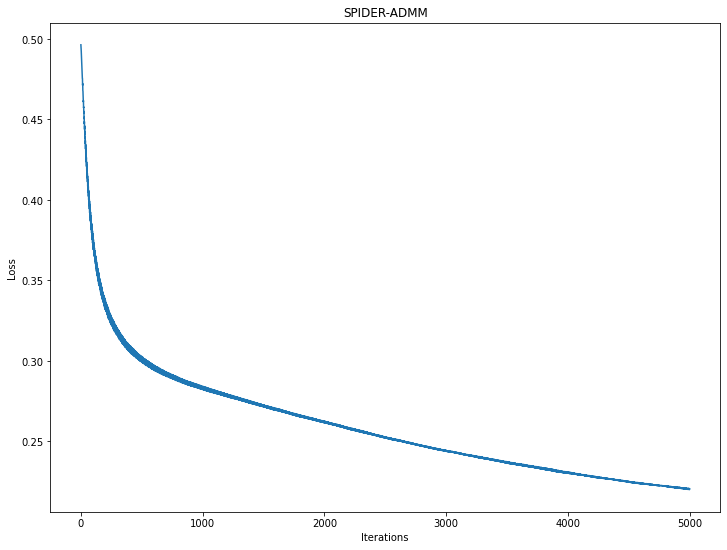

In [61]:
plt.figure(figsize=(12,9))
plt.plot(output_spider[-1])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SPIDER-ADMM")
plt.show()

In [85]:
#U = X_train
#w = y_train
def SAGA_admm(K, eta, rho, U, w, A, lambda_):
    d_z = {} # dictionary of z_s
    
    n, d = U.shape
    x = np.zeros((d,1)) # x0
    y = np.zeros((d,1)) # y0
    lamb = np.zeros((d,1)) # init 
    w = w.reshape((len(w), 1))
    B = -np.eye(d)
    c = np.zeros((d,1))
    #dual residual
    s = np.zeros((d,1))
    #primal residual
    r = np.zeros((d,1))

    
    i = 0
    loss = []
    
    # PSI INIT
    psi  = gradf(U, w, np.zeros((d,1)))
    
    for k in range(K):
        # Uniformly randomly pick i_t and j_t from [1,n]
        it, jt = np.random.randint(n), np.random.randint(n)
        
        # Grab z (might have to fix this) is it really z_it ^ t
        z = None
        if it not in d_z:
            d_z[it] = np.zeros((d,1))
        if jt not in d_z:
            d_z[jt] = np.zeros((d,1))
        z = d_z[it]
        
        # Update rho
        rho = update_rho(rho, r, s)
        
        # Update y
        y = update_y(x, y, lamb, rho, A, lambda_)
        
        # Compute gradient
        Ub, wb = U[it:it+1, :], w[it:it+1]
        vk = gradf(Ub, wb, x) - gradf(Ub, wb, z) + psi
        
        # Update x
        xprev = x.copy()
        x = update_x(x, y, lamb, vk, rho, eta, A)
        
        # Update lamb
        lamb_0 = lamb.copy()
        lamb = lamb - rho * (A @ x + B @ y - c)
        
        # Update z
        z_jt_prev = d_z[jt]
        d_z[jt] = xprev
        
        # Update psi
        Ub, wb = U[jt:jt+1, :], w[jt:jt+1]
        psi = psi - 1/n * (gradf(Ub, wb,  z_jt_prev) - gradf(Ub, wb, d_z[jt]))
        
        # Update s/r
        s = update_s(rho, A, B, z_1=lamb, z_0=lamb_0)
        r = update_r(A, B, x, lamb, c)

        l = lossfn(U, w, x, A, lambda_)
        if k % 100 == 0:
            # print("k:", k, "Loss:", l)
            print("k:", k,"rho:",rho,"r:",np.linalg.norm(r, ord=2),"s:",np.linalg.norm(s, ord=2),"Loss:", l)
        loss.append(l)
    
    return x, y, z, loss

In [63]:
eta = 0.05
rho = 0.5
lambda_ = 1e-5
K = 5000
output_saga = SAGA_admm(K, eta, rho, X_train, y_train, A, lambda_)

k: 0 rho: 0.5 r: 0.08974119733835727 s: 0.06959822651037491 Loss: 0.496397769234622
k: 100 rho: 1.9073486328125 r: 2.5250870666154457 s: 2.3665233241634356 Loss: 0.3680286448797923
k: 200 rho: 1.9073486328125 r: 4.756806179135624 s: 4.687627881366656 Loss: 0.32337925526238753
k: 300 rho: 2.384185791015625 r: 7.172565493136086 s: 30.426208172575407 Loss: 0.31188522468568064
k: 400 rho: 1.220703125 r: 6.37469208193534 s: 2.3112618149295554 Loss: 0.3058874215221168
k: 500 rho: 1.52587890625 r: 7.371563655942832 s: 5.5793624780791555 Loss: 0.3001806307488903
k: 600 rho: 1.52587890625 r: 7.393526089330153 s: 9.582479264585425 Loss: 0.2989954230932993
k: 700 rho: 1.9073486328125 r: 6.3946847837696374 s: 11.582005857197483 Loss: 0.3019898075521563
k: 800 rho: 2.384185791015625 r: 7.778215006476327 s: 3.049239651605236 Loss: 0.2978223734189526
k: 900 rho: 1.220703125 r: 9.582716337497354 s: 7.561223501865207 Loss: 0.28815615541474715
k: 1000 rho: 1.52587890625 r: 10.83641973893552 s: 14.928721

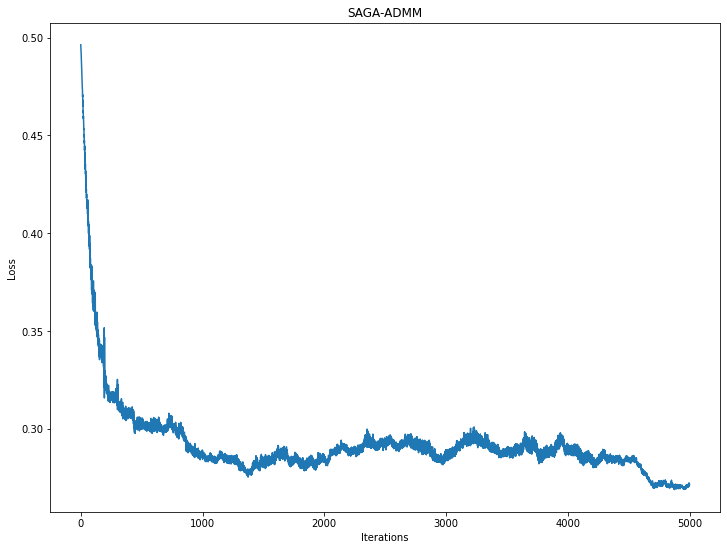

In [64]:
plt.figure(figsize=(12,9))
plt.plot(output_saga[-1])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SAGA-ADMM")
plt.show()

In [86]:
def svrg_admm(m, T, eta, rho, U, w, A, lambda_):
    n, d = U.shape
    x = np.zeros((d,1)) # ai^\top x_i 
    y = np.zeros((d,1)) # Ay
    z = np.zeros((d,1)) # 
    w = w.reshape((len(w), 1))
    B = -np.eye(d)
    c = np.zeros((d,1))
    #dual residual
    s = np.zeros((d,1))
    #primal residual
    r = np.zeros((d,1))

    S = T // m # No. of epochs
    xs = x.copy()
    loss = []

    for e in range(S):
        dxs = gradf(U, w, xs)
        for t in range(m):
            i = np.random.randint(n)
            rho = update_rho(rho, r, s)
            
            y = update_y(x, y, z, rho, A, lambda_)

            Ub, wb = U[i:i+1, :], w[i:i+1,:]
            dx = gradf(Ub, wb, x) - gradf(Ub, wb, xs) + dxs
            
            x = update_x(x, y, z, dx, rho, eta, A)
            
            z_0 = z.copy()
            z = z - rho * (A @ x + B @ y - c)
            
            s = update_s(rho, A, B, z_1=z, z_0=z_0)
            r = update_r(A, B, x, z, c)

            l = lossfn(U, w, x, A, lambda_)
            
            k = e * m + t
            if k % 100 == 0:
                # print("k:", k, "Loss:", l)
                print("k:", k,"rho:",rho,"r:",np.linalg.norm(r, ord=2),"s:",np.linalg.norm(s, ord=2),"Loss:", l)
            loss.append(l)
        
        xs = x.copy()

    
    return x, y, z, loss

In [87]:
eta = 0.05
rho = 0.5
lambda_ = 1e-5
m = 10
T = 5000
output_svrg = svrg_admm(m, T, eta, rho, X_train, y_train, A, lambda_)

k: 0 rho: 0.5 r: 0.08974119733835727 s: 0.06959822651037491 Loss: 0.496397769234622
k: 100 rho: 1.9073486328125 r: 2.6288130685828737 s: 2.3390607450834016 Loss: 0.3715114796140156
k: 200 rho: 1.52587890625 r: 3.939857855092965 s: 2.538682410322596 Loss: 0.3325302825910614
k: 300 rho: 1.9073486328125 r: 4.921464182838708 s: 5.5176743168477165 Loss: 0.315619805285404
k: 400 rho: 1.52587890625 r: 5.4667189736119095 s: 3.868055498304367 Loss: 0.30595805633587453
k: 500 rho: 1.9073486328125 r: 6.103610485401059 s: 7.404052725956326 Loss: 0.2994751973260855
k: 600 rho: 1.52587890625 r: 6.3344557908651895 s: 4.517954884849036 Loss: 0.2947800687400689
k: 700 rho: 1.52587890625 r: 6.81372239145451 s: 6.526530808471631 Loss: 0.2905487049094795
k: 800 rho: 1.9073486328125 r: 7.132849003692194 s: 8.206439573815075 Loss: 0.287688885142169
k: 900 rho: 1.9073486328125 r: 7.359595471772792 s: 7.429653827748824 Loss: 0.2849121326390988
k: 1000 rho: 1.52587890625 r: 7.521706339503413 s: 5.5346067127713

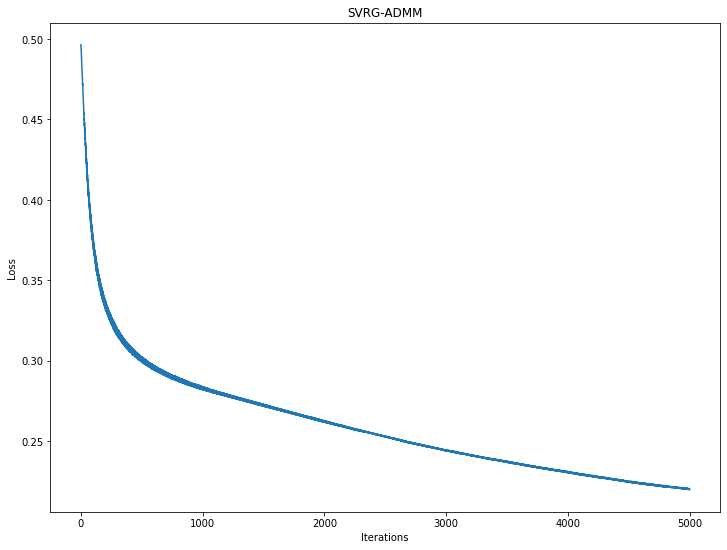

In [68]:
plt.figure(figsize=(12,9))
plt.plot(output_svrg[-1])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SVRG-ADMM")
plt.show()

In [69]:
def s_admm(K, eta, rho, U, w, A, lambda_):
    n, d = U.shape
    x = np.zeros((d,1)) # ai^\top x_i 
    y = np.zeros((d,1)) # Ay
    z = np.zeros((d,1)) # 
    w = w.reshape((len(w), 1))
    B = -np.eye(d)
    c = np.zeros((d,1))
    #dual residual
    s = np.zeros((d,1))
    #primal residual
    r = np.zeros((d,1))

    loss = []

    for k in range(K):
        i = np.random.randint(n)
        rho = update_rho(rho, r, s)
        
        y = update_y(x, y, z, rho, A, lambda_)

        Ub, wb = U[i:i+1, :], w[i:i+1,:]
        dx = gradf(Ub, wb, x)
        
        x = update_x(x, y, z, dx, rho, eta, A)
        
        z_0 = z.copy()
        z = z - rho * (A @ x + B @ y - c)
        
        s = update_s(rho, A, B, z_1=z, z_0=z_0)
        r = update_r(A, B, x, z, c)

        l = lossfn(U, w, x, A, lambda_)
        
        # print("k:", k, "Loss:", l)
        if k % 100 == 0:
            print("k:", k,"rho:",rho,"r:",np.linalg.norm(r, ord=2),"s:",np.linalg.norm(s, ord=2),"Loss:", l)
        
        loss.append(l)
    
    
    
    return x, y, z, loss

In [70]:
eta = 0.05
rho = 0.5
lambda_ = 1e-5
K = 5000
output_s = s_admm(K, eta, rho, X_train, y_train, A, lambda_)

k: 0 rho: 0.5 r: 0.39358299173261657 s: 0.2474409147708741 Loss: 0.48995151367188383
k: 100 rho: 1.52587890625 r: 2.735470175687645 s: 1.5546537445969526 Loss: 0.3880809892114666
k: 200 rho: 1.9073486328125 r: 4.189420180832604 s: 0.4900026021861658 Loss: 0.3480520760883321
k: 300 rho: 1.9073486328125 r: 5.247695750497774 s: 3.9823379055787917 Loss: 0.33458618001204354
k: 400 rho: 1.9073486328125 r: 5.0807478045798105 s: 5.996385740553776 Loss: 0.3268557966826871
k: 500 rho: 1.9073486328125 r: 5.520181649804299 s: 6.805376086326459 Loss: 0.31448021179214997
k: 600 rho: 1.52587890625 r: 6.126494621456291 s: 6.2611509534079355 Loss: 0.30724280649148444
k: 700 rho: 1.52587890625 r: 6.246717580836473 s: 4.9544133940498325 Loss: 0.3100923819363325
k: 800 rho: 1.9073486328125 r: 6.149834568868048 s: 9.984746106611436 Loss: 0.3069777186965667
k: 900 rho: 1.52587890625 r: 6.880743258310381 s: 5.64973874231518 Loss: 0.300379108488264
k: 1000 rho: 1.9073486328125 r: 7.2054603581666266 s: 9.35539

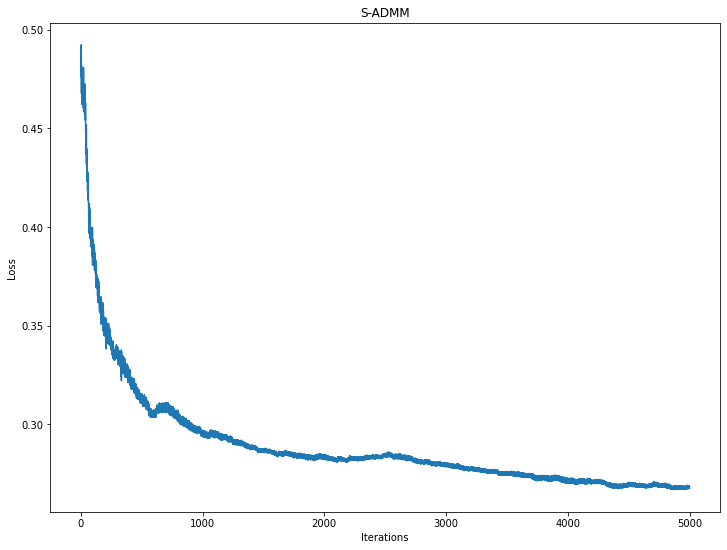

In [71]:
plt.figure(figsize=(12,9))
plt.plot(output_s[-1])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("S-ADMM")
plt.show()

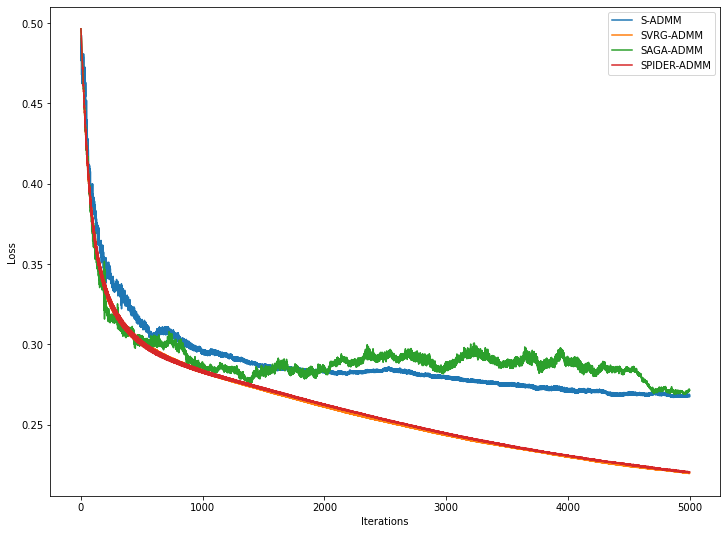

In [90]:
plt.figure(figsize=(12,9))
plt.plot(output_s[-1], label='S-ADMM')
plt.plot(output_svrg[-1], label='SVRG-ADMM')
plt.plot(output_saga[-1], label='SAGA-ADMM')
plt.plot(output_spider[-1], label='SPIDER-ADMM')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig('admm.png', dpi=200)
plt.show()